#**Notebook do projeto do módulo 3 da Inteli realizado pelo G3-Dev**

Ola eu sou a **Emily** a inteligência artificial desenvolvida pelos alunos Inteli, Instituto de Tecnologia e Liderança, do grupo G3-Dev, constituído por:

Alan Rozensztajn Schipper;

Beny Frid;

Felipe Gomes Rodrigues dos Santos;

Gustavo Monteiro;

Mateus Guimarães Coelho Neves e,

Stefano Matiotta Tinelli.

Sob a orientação da Professora Ana Cristina dos Santos, durante o módulo 3, do 2º semestre, com parceria da empresa Everymind.

**Observação**: Este projeto foi desenvolvido, com cunho acadêmico, no intuito de dar suporte na tomada de decisões de um gestor, na utilização de modelagem preditiva, sendo importante **destacar a responsabilidade ao ser utilizado.**

#**1. Introdução**

Construção de um modelo preditivo, utilizando dados amostrais anonimizados referentes aos últimos dois anos (referentes do ano 2020 ao ano 2022) de colaboradores da empresa, para classificação de funcionários que desejam se desligar da empresa. Decorre também deste projeto verificar o desempenho entre diferentes algoritmos de Machine Learning, em relação ao contexto da problemática levantada pelo parceiro de negócios, sobre a rotatividade de colaboradores na empresa.

O tipo de modelagem preditiva utilizada neste projeto é o de classificação binária, que consiste em classificar os elementos do conjunto de dados em dois tipos de classes,  “1” e “0”, onde o funcionário ATIVO é representado plo valor binário "1", e o funcionário DESLIGADO é representado pelo valor binário "0".


# **2. Importação**

##2.1 Importação de Bibliotecas


In [98]:
!pip install moment

import pandas as pd
import numpy as np 
import datetime as dt
from datetime import date
from datetime import datetime
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.metrics import plot_confusion_matrix
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

%matplotlib inline

from sklearn.preprocessing import LabelEncoder

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


##2.2 Importação da Base de Dados


Os dados enviados pelo cliente (Everymind - a compass.uol company) consistem em um documento do Google Sheets em formato .XLSX contendo um total de três tabelas, importadas a seguir:


In [99]:
from google.colab import data_table
data_table.enable_dataframe_formatter()

pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

from google.colab import drive
drive.mount('/content/drive')

df = pd.read_excel('/content/drive/Shareddrives/modoulo3-grupo3/Base Colaboradores Everymind_Inteli_2020 a 2022vModelo Preditivo.xlsx', 'Everymind')
df_rec = pd.read_excel('/content/drive/Shareddrives/modoulo3-grupo3/Base Colaboradores Everymind_Inteli_2020 a 2022vModelo Preditivo.xlsx', 'Reconhecimento')
df_amb = pd.read_excel('/content/drive/Shareddrives/modoulo3-grupo3/Base Colaboradores Everymind_Inteli_2020 a 2022vModelo Preditivo.xlsx', 'Ambiente de Trabalho 27.07')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# **3. Tratamento de Dados(Tabela Everymind)**

**Preparação**

A fase de preparação de dados abrange todas as atividades para construir o conjunto de dados final a partir dos dados brutos iniciais. Essa etapa compreende a seleção por atributos desses dados não tratados e a partir disso a limpeza dos mesmos. Assim, desenvolve-se o tratamento desses dados, alterando/retirando caracteres especiais, espaços, agregações, que podem acabar dificultando ou impossibilitando a utilização deles em um modelo.

Na tabela “Everymind” existem diferentes tipos de dados, que podem ser enriquecidos com variáveis da tabela “Reconhecimento”. Mas antes foi feito o tratamento dos dados.

## 3.1 Apaga o index e define novamente

In [100]:
def resetIndex(data): 
  e = data[data.columns[1]].count() 
  ID = []
  i = 0
  while i < e:
    ID.append(i)
    i += 1

  data['index'] = ID
  data.set_index('index', inplace= True)

##3.2 Remove os acentos e caracteries especiais  


In [101]:
df.rename(columns = {'Escolaridade ':'Escolaridade'}, inplace = True)
char = ['Data',' ', 'á', 'ã', 'é', 'ê', 'í', 'ó', 'ú', 'ç', '_de_']
sub_char = ['Dt','_', 'a', 'a', 'e', 'e', 'i', 'o', 'u', 'c', '_']

for i in char:
  e = char.index(i)
  df.columns = df.columns.str.replace(char[e], sub_char[e])
  df_rec.columns = df_rec.columns.str.replace(char[e], sub_char[e])

##3.3 Padroniza as data 

In [102]:
today = date.today()
df['Dt_Admissao']= pd.to_datetime(df['Dt_Admissao'])
df['Dt_Admissao'] = df["Dt_Admissao"].dt.strftime("%m-%d-%y")
df['Dt_Admissao']= pd.to_datetime(df['Dt_Admissao'])

df['Dt_Saida']= pd.to_datetime(df['Dt_Saida'])
df['Dt_Saida'] = df["Dt_Saida"].dt.strftime("%m-%d-%y")
df = df.replace(to_replace={'Dt_Saida':{np.nan:today}}, value=None)
df['Dt_Saida']= pd.to_datetime(df['Dt_Saida'])

##3.4 Remove espaços e muda PessoaColaboradora para PC

In [103]:
dtg = df.select_dtypes(include = "object").columns
for a in dtg:
  df[a] = df[a].str.replace(' ', '')
  df[a] = df[a].str.replace('PessoaColaboradora', 'PC')

dtg = df_rec.select_dtypes(include = "object").columns
for a in dtg:
  df_rec[a] = df_rec[a].str.replace(' ', '')
  df_rec[a] = df_rec[a].str.replace('PessoaColaboradora', 'PC')

##3.5 Cria a coluna NumeroMeses que calcula o período do funcionário

In [104]:
  def numOfDays(date1, date2):
    return (date2-date1).days

df['NumeroMeses'] = ""


for i in range(0, len(df['Dt_Admissao'])):
    if df['Tipo_Saida'][i] == str('Ativo'):
        df['NumeroMeses'][i] = (((date.today().year - df['Dt_Admissao'][i].year)*12)+date.today().month - df['Dt_Admissao'][i].month)
    else:
        df['NumeroMeses'][i] = (df['Dt_Saida'][i].year - df['Dt_Admissao'][i].year)*12+df['Dt_Saida'][i].month - df['Dt_Admissao'][i].month

df_rec['Numero_Dias'] = ""


for i in range(0, len(df_rec['Dt_Admissao'])):
    df_rec['Numero_Dias'][i] = df_rec['Dt_Vigencia'][i] - df_rec['Dt_Admissao'][i]
    df_rec['Numero_Dias'][i] = df_rec['Numero_Dias'][i].days

df['NumeroMeses'] = df.NumeroMeses.astype(float)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


##3.6 Cria a coluna situação 

In [105]:
df['Situacao']= np.nan
df = df.replace(to_replace={'Tipo_Saida':{np.nan:'nulo'}}, value=None)

for i in df.index:
    if df['Tipo_Saida'][i]== 'nulo':
        df['Situacao'][i] = 1
    else:
        df['Situacao'][i] = 0

df_rec = pd.get_dummies(df_rec, columns = ['Situacao'])
df_rec = df_rec.drop(['Matricula', 'Situacao_Afastado', 'Situacao_Desligado'],axis=1)
df_rec.rename(columns = {'Situacao_Ativo':'Situacao'}, inplace = True)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


##3.7 Utiliza o *dummies* para gerar uma coluna de 1 e 0 para cada variável das colunas abaixo 

Dummies são uma técnica de tranformar valores de uma variável em diversas variáveis binárias de cada valor da variável original, sendo importante para possibilitar a fórmula matemática do algoritmo do modelo de predição a utilizar estes valores biários em sua predição.

In [106]:
df = pd.get_dummies(df, columns = ['Cargo'])
df = pd.get_dummies(df, columns = ['Estado_Civil'])
df = pd.get_dummies(df, columns = ['Escolaridade'])
df = pd.get_dummies(df, columns = ['Estado'])
df = pd.get_dummies(df, columns = ['Cidade'])

##3.8 Define Masculino como 1 e feminino como 0 

In [107]:
df.Genero[df.Genero == 'Masculino'] = 1
df.Genero[df.Genero == 'Feminino'] = 0

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


##3.9 Define as colunas para tipo *float*

In [108]:
df['Genero'] = df.Genero.astype(float)

##3.10 Remove algumas colunas

In [109]:
df = df.drop(['Matricula','Dt_Nascimento', 'Dt_Saida', 'Etnia'],axis=1)

##3.11 Remove colunas e organiza a tabela de roconhecimento


In [110]:
df_mod = df_rec
df_mod = df_mod.drop(['Novo_Cargo','Novo_Salario', 'Motivo', 'Alterou_Funcao'],axis=1)
df_mod = df_mod.sort_values( by="Codinome", ascending=True)

##3.12 Remove a duplicação da tabela de reconhecimento 


In [111]:
df_alt = df_mod.drop_duplicates(subset='Codinome', keep = 'first')
df_dupl = df_mod.loc[df_mod.duplicated(subset='Codinome')]
resetIndex(df_alt) 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':


##3.13 Remove da tabela informações de pessoas dispensadas sem justa causa ou com recisão de contrato


In [112]:
n = 0
for i in df['Tipo_Saida']:
  if i == 'DispensasemJustaCausa' or i == 'RescisaoContratoExp-Dispensa':
    df = df.drop(n)
    resetIndex(df)
  else:
    n += 1

##3.14 Cria uma coluna para todas as promoções 


In [113]:
df_alt['@1'], df_alt['@2'], df_alt['@3'], df_alt['@4'], df_alt['@5'], df_alt['@6'], df_alt['Numero_Promocoes'], df_alt['Tempo_Medio_Promocoes'] = ['0', '0', '0', '0', '0', '0', '0', '0']
df_alt.columns = df_alt.columns.str.replace('@', 'Promocao_')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


##3.15 Remove as linhas da tabela de reconhecimento onde a pessoa se repete e define em uma linha todas as promoção do colaborador, em sequência


In [114]:
for i in df_alt.index:
  e = df_alt['Codinome'][i]
  df_temp = df_mod.query("Codinome in @e").sort_values( by="Numero_Dias", ascending=True)
  resetIndex(df_temp)
  for e in df_temp.index:
    if e == 0:
      df_alt['Promocao_1'][i] = df_temp['Numero_Dias'][e]
      df_alt['Numero_Promocoes'][i] = 1
    elif e == 1:
      df_alt['Promocao_2'][i] = df_temp['Numero_Dias'][e]
      df_alt['Numero_Promocoes'][i] = 2
    elif e == 2:
      df_alt['Promocao_3'][i] = df_temp['Numero_Dias'][e]
      df_alt['Numero_Promocoes'][i] = 3
    elif e == 3:
      df_alt['Promocao_4'][i] = df_temp['Numero_Dias'][e]
      df_alt['Numero_Promocoes'][i] = 4
    elif e == 4:
      df_alt['Promocao_5'][i] = df_temp['Numero_Dias'][e]
      df_alt['Numero_Promocoes'][i] = 5
    elif e == 5:
      df_alt['Promocao_6'][i] = df_temp['Numero_Dias'][e]
      df_alt['Numero_Promocoes'][i] = 6

df_alt.drop(['Numero_Dias', 'Dt_Vigencia'], axis=1, inplace=True)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python3.7/dist-packages/ipyke

##3.16 Calcula a média de tempo para todos os funcionários receberem a primeira promoção 


In [115]:
df_alt_mean = '{:.1f}'.format(df_alt['Promocao_1'].mean())
df_alt_mean

'488.2'

##3.17 Calcula a média de tempo para promoção de cada funcionário


In [116]:
for i in df_alt.index:
  if df_alt['Numero_Promocoes'][i] == 1:
    df_alt['Tempo_Medio_Promocoes'][i] = int(df_alt['Promocao_1'][i]/df_alt['Numero_Promocoes'][i])
  elif df_alt['Numero_Promocoes'][i] == 2:
    df_alt['Tempo_Medio_Promocoes'][i] = int(df_alt['Promocao_2'][i]/df_alt['Numero_Promocoes'][i])
  elif df_alt['Numero_Promocoes'][i] == 3:
    df_alt['Tempo_Medio_Promocoes'][i] = int(df_alt['Promocao_3'][i]/df_alt['Numero_Promocoes'][i])
  elif df_alt['Numero_Promocoes'][i] == 4:
    df_alt['Tempo_Medio_Promocoes'][i] = int(df_alt['Promocao_4'][i]/df_alt['Numero_Promocoes'][i])
  elif df_alt['Numero_Promocoes'][i] == 5:
    df_alt['Tempo_Medio_Promocoes'][i] = int(df_alt['Promocao_5'][i]/df_alt['Numero_Promocoes'][i])
  elif df_alt['Numero_Promocoes'][i] == 6:
    df_alt['Tempo_Medio_Promocoes'][i] = int(df_alt['Promocao_6'][i]/df_alt['Numero_Promocoes'][i])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
/usr/local/lib

##3.18 Renomeia Codinome para Nome_Completo


In [117]:
df_alt.rename(columns = {'Codinome':'Nome_Completo'}, inplace = True)
df = df.sort_values( by="Nome_Completo", ascending=True)
resetIndex(df)

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:5047: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


##3.19 Faz a integração entre a tabela principal com a de reconhecimento 


In [118]:
integrated_dfs = pd.merge(df, df_alt,how="left", on= ["Nome_Completo", "Dt_Admissao", "Situacao"])

##3.20 Define as informações nulas para 0 


In [119]:
integrated_dfs = integrated_dfs.fillna(0)

##3.21 Cria uma coluna para a primiera promoção


In [120]:
integrated_dfs['Media_Prmc_1'] = df_alt_mean

#**4. Tratamento de Dados(Tabela Ambiente de Trabalho)**

A partir da análise feita nesta tabela, os dados presentes não se relacionam diretamente com os dados da tabela principal, dificultando a aplicação e integração desta tabela, mesmo com tratamento dos dados, resultando em uma perda significativa de dados, trazendo uma considerável quantidade de ruídos.

##4.1 Descarta os colaboradores das áreas de BAC e Produtos


In [121]:
n = 0
for i in integrated_dfs['Area']:
  if i == 'BAC' or i == 'Produtos':
    integrated_dfs = integrated_dfs.drop(n)
    resetIndex(integrated_dfs)
  else:
    n += 1

##4.2 Listagem das áreas


In [122]:
listaArea = integrated_dfs['Area'].unique()
listaArea = list(listaArea)
listaArea.sort()
listaArea.remove('CPG&Retail')
listaArea.remove('Commerce')
listaArea.remove('Core&Industrias')
listaArea.remove('MktCloud')
listaArea.remove('People')
listaArea.remove('Vendas')

sub_char4 = ['AMS&PS','MktCloud','Analytics&Integration','Everymind','Everymind','CPG&Retail','CPG&Retail','Core&Industrias','Core&Industrias','Everymind','Everymind','Everymind','Everymind','Analytics&Integration','AMS&PS',]

##4.3 Padronização das áreas em ambas as tabelas


In [123]:
n = 0
dtg = df.select_dtypes(include = "object").columns
for i in listaArea:
  for a in dtg:
    integrated_dfs[a] = integrated_dfs[a].replace(listaArea[n], sub_char4[n])
  n += 1

##4.4 Remove os acentos e caracteres especiais  


In [124]:
char = ['Data',' ', 'á', 'ã', 'é', 'ê', 'í', 'ó', 'ú', 'ç', '_de_','-']
sub_char = ['Dt','_', 'a', 'a', 'e', 'e', 'i', 'o', 'u', 'c', '_','']

for i in char:
  e = char.index(i)
  df_amb.columns = df_amb.columns.str.replace(char[e], sub_char[e])

df_amb = df_amb.sort_values( by="Taxa_Confiabilidade", ascending=True)
resetIndex(df_amb)

## 4.5 Retira espaços e substitui vírgulas por pontos


In [125]:
dtg = df_amb.select_dtypes(include = "object").columns
for a in dtg:
  df_amb[a] = df_amb[a].str.replace(' ', '')
  df_amb[a] = df_amb[a].str.replace(',', '.')

df_amb = df_amb.drop(['Pergunta', 'Fator', 'Pontuacao.1', 'Pulou', 'Muito_Insatisfeito', 'Insatisfeito', 'Neutro', 'Satisfeito', 'Muito_Satisfeito'],axis=1)

## 4.6 Remove fatores com taxa de confiabilidade baixa e muito baixa


In [126]:
n = 0
for i in df_amb['Taxa_Confiabilidade']:
  if i == 'MuitoBaixo' or i == 'Baixo':
    df_amb = df_amb.drop(n)
    resetIndex(df_amb)
  else:
    n += 1

char = list(df_amb['Divisao'].unique())

##4.7 Remove duplicatas da tabela


In [127]:
df_amb = df_amb.sort_values( by=["Divisao","Pilar"], ascending=True)
resetIndex(df_amb)

df_temp = df_amb.drop_duplicates(subset=['Divisao','Pilar'], keep = 'first')
df_dupl = df_amb.loc[df_amb.duplicated(subset=['Divisao','Pilar'])]
resetIndex(df_dupl)

pilarList = list(df_dupl['Pilar'].unique())

df_dupl = pd.get_dummies(df_dupl, columns= ['Pilar'])

df_dupl.columns = df_dupl.columns.str.replace('Pilar_', '')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':


##4.8 Separa em colunas os valores por pilar


In [128]:
for e in df_dupl.index:
  for i in pilarList:
    if df_dupl[i][e] == 1:
      df_dupl[i][e] = df_dupl['Pontuacao'][e]
      
df_amb = df_dupl.drop_duplicates(subset=['Divisao'], keep = 'first')
resetIndex(df_amb)
df_amb

df_dupl = df_dupl.drop(['Taxa_Confiabilidade', 'Pontuacao'], axis=1)
df_amb = df_amb.drop(['Taxa_Confiabilidade', 'Pontuacao'], axis=1)

for i in df_amb.index:
  for e in df_dupl.index:
    if df_amb['Divisao'][i] == df_dupl['Divisao'][e]:
      for n in pilarList:
        if df_dupl[n][e] != 0:
          df_amb[n][i] = df_dupl[n][e]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexin

##4.9 Listagem de colunas


In [129]:
listaColumns = df_amb.columns.unique()
listaColumns = list(listaColumns)
listaColumns.sort()
listaColumns.remove('Divisao')

##4.10 Conversão para valores *float* e média de valores diferentes para mesma área


In [130]:
for n in df_amb.index:
  for i in listaColumns:
    df_amb[i] = df_amb[i].astype(float)
    if df_amb['Divisao'][n] == 'CPG&RetailI':
      if df_amb[i][n] != 0 and df_amb[i][n+1] != 0:
        df_amb[i][n] = '{:.2f}'.format((df_amb[i][n]+df_amb[i][n+1])/2)
      elif df_amb[i][n] == 0 or df_amb[i][n+1] == 0:
        df_amb[i][n] = '{:.2f}'.format(df_amb[i][n] + df_amb[i][n+1])
    if df_amb['Divisao'][n] == 'Core&IndustriasI':
      if df_amb[i][n] != 0 and df_amb[i][n+1] != 0:
        df_amb[i][n] = '{:.2f}'.format((df_amb[i][n]+df_amb[i][n+1])/2)
      elif df_amb[i][n] == 0 or df_amb[i][n+1] == 0:
        df_amb[i][n] = '{:.2f}'.format(df_amb[i][n]+df_amb[i][n+1])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  del sys.path[0]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 


##4.11 Remove áreas duplicadas


In [131]:
for n in df_amb.index:  
  if n == 9:
    break
  elif df_amb['Divisao'][n] == 'CPG&RetailII' or df_amb['Divisao'][n] == 'Core&IndustriasII':
    df_amb = df_amb.drop([n], axis=0)
    resetIndex(df_amb)

dtg = df_amb.select_dtypes(include = "object").columns
for a in dtg:
  df_amb[a] = df_amb[a].str.replace('CPG&RetailI', 'CPG&Retail')
  df_amb[a] = df_amb[a].str.replace('Core&IndustriasI', 'Core&Industrias')
  df_amb[a] = df_amb[a].str.replace('People&Culture', 'People')

##4.12 Renomeia coluna divisão e padroniza para a integração com a tabela principal


In [132]:
df_amb.rename(columns = {'Divisao':'Area'}, inplace = True)
integrated_dfs = pd.merge(integrated_dfs, df_amb,how="left", on=['Area'])

integrated_dfs = pd.get_dummies(integrated_dfs, columns = ['Area'])

#**5. Tabela Final**

In [133]:
integrated_dfs

,Nome_Completo,Dt_Admissao,Tipo_Saida,Salario_Mes,Genero,NumeroMeses,Situacao,Cargo_Arquiteto,Cargo_ArquitetoSr,Cargo_AssistenteI,Cargo_AssistenteII,Cargo_AuxiliardeLimpeza,Cargo_ComercialIS,Cargo_ComercialPl,Cargo_Consultor,Cargo_DevEspecialista,Cargo_DevJr,Cargo_DevPl,Cargo_DevSr,Cargo_Diretor,Cargo_EducaçãoPl,Cargo_Estagiaria,Cargo_FinanceiroJr,Cargo_FuncionalEspecialista,Cargo_FuncionalJr,Cargo_FuncionalPl,Cargo_FuncionalSr,Cargo_Gerente,Cargo_GerenteCSSr,Cargo_GerentePV,Cargo_GerenteSr,Cargo_GerenteVendasI,Cargo_GerenteVendasII,Cargo_GerenteVendasIII,Cargo_InfraestruturaJr,Cargo_MarketingPL,Cargo_PessoasPl,Cargo_ScrumMasterJr,Cargo_TesteJr,Cargo_TesteSr,Cargo_Trainee-Dev,Cargo_Trainee-Funcional,Cargo_VicePresidente,Estado_Civil_Casado,Estado_Civil_Divorciado,Estado_Civil_Separado,Estado_Civil_Solteiro,Estado_Civil_UniãoEstável,Escolaridade_EnsinoMédio,Escolaridade_EnsinoMédioIncompleto,Escolaridade_Graduação,Escolaridade_Mestrado,Escolaridade_PósGraduação,Escolaridade_Superiorincompleto,Escolaridade_Técnico,Estado_BA,Estado_CE,Estado_DF,Estado_GO,Estado_MA,Estado_MG,Estado_MS,Estado_PA,Estado_PB,Estado_PE,Estado_PR,Estado_RJ,Estado_RN,Estado_RS,Estado_SC,Estado_SE,Estado_SP,Cidade_Abaetetuba,Cidade_Alfenas,Cidade_Ananindeua,Cidade_Anápolis,Cidade_Atibaia,Cidade_Bacabal,Cidade_BalneárioCamboriú,Cidade_Barueri,Cidade_BelaVistadeGoiás,Cidade_BeloHorizonte,Cidade_Belém,Cidade_BragançaPaulista,Cidade_Brasília,Cidade_Cabedelo,Cidade_Cabreúva,Cidade_Caieiras,Cidade_Camaragibe,Cidade_Campinas,Cidade_CampoGrande,Cidade_CampoLimpoPaulista,Cidade_Canoas,Cidade_Carapicuíba,Cidade_Catanduvas,Cidade_Caucaia,Cidade_Charqueadas,Cidade_Colombo,Cidade_Concórdia,Cidade_Congonhas,Cidade_Contagem,Cidade_Cotia,Cidade_Curitiba,Cidade_Diadema,Cidade_Divinópolis,Cidade_DoisVizinhos,Cidade_Embu-Guaçu,Cidade_Erechim,Cidade_Eusébio,Cidade_Florianópolis,Cidade_Fortaleza,Cidade_Franca,Cidade_FranciscoBeltrão,Cidade_FranciscoMorato,Cidade_Garanhuns,Cidade_Guaimbê,Cidade_Guaiçara,Cidade_Guarulhos,Cidade_Hortolândia,Cidade_Igarapé,Cidade_Igarassu,Cidade_Indaiatuba,Cidade_Ipanema,Cidade_Itaiópolis,Cidade_Itanhaém,Cidade_ItapecericadaSerra,Cidade_Itapevi,Cidade_Itaquaquecetuba,Cidade_Jandira,Cidade_JoãoPessoa,Cidade_JuazeirodoNorte,Cidade_Jundiaí,Cidade_Limeira,Cidade_Londrina,Cidade_Mafra,Cidade_Mairiporã,Cidade_Maricá,Cidade_Maringá,Cidade_Mauá,Cidade_MogiMirim,Cidade_MogidasCruzes,Cidade_Navegantes,Cidade_Niterói,Cidade_NovaIguaçu,Cidade_NovaLima,Cidade_NovoHamburgo,Cidade_Osasco,Cidade_Palmital,Cidade_Patos,Cidade_Paulista,Cidade_Paulínia,Cidade_PedroLeopoldo,Cidade_Pelotas,Cidade_Pindamonhangaba,Cidade_Piracicaba,Cidade_PortoAlegre,Cidade_Poá,Cidade_PraiaGrande,Cidade_PresidentePrudente,Cidade_Promissão,Cidade_RafaelFernandes,Cidade_Recife,Cidade_RibeirãoPires,Cidade_RibeirãoPreto,Cidade_RioGrande,Cidade_RioNegro,Cidade_RiodeJaneiro,Cidade_Salgado,Cidade_Salvador,Cidade_SantaBárbaraD'Oeste,Cidade_SantaMariadaVitória,Cidade_SantaMariadoPará,Cidade_SantanadeParnaíba,Cidade_SantoAndré,Cidade_Santos,Cidade_Sertãozinho,Cidade_Sobral,Cidade_Sorocaba,Cidade_Suzano,Cidade_SãoBernardodoCampo,Cidade_SãoCaetanodoSul,Cidade_SãoCristóvão,Cidade_SãoJosé,Cidade_SãoLourenço,Cidade_SãoPaulo,Cidade_SãoVicente,Cidade_TaboãodaSerra,Cidade_Taubaté,Cidade_Uberlândia,Cidade_Unaí,Cidade_Vinhedo,Promocao_1,Promocao_2,Promocao_3,Promocao_4,Promocao_5,Promocao_6,Numero_Promocoes,Tempo_Medio_Promocoes,Media_Prmc_1,Alinhamento,Bem-estar,Crescimentopessoal,Feedback,Felicidade,Reconhecimento,Relacionamentocomaequipe,Relacionamentocomogestor,Satisfação,Vestiracamisa,Area_AMS&PS,Area_Analytics&Integration,Area_CPG&Retail,Area_Commerce,Area_Core&Industrias,Area_Everymind,Area_MktCloud,Area_People,Area_Vendas
0,PC1,2022-06-06,nulo,2250.0,1.0,4.0,1.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,

#**6. Determinação de variaveis**


**Modelagem**

O analista avalia, seleciona e aplica as técnicas de mineração de dados mais apropriadas, dependendo dos objetivos identificados na primeira fase. Assim é possível descobrir e analisar padrões nos dados 

Para o teste do modelho escolhido,foram utilizados o conjunto de variáveis citadas a seguir:

Salário;

Gênero;

Período na empresa;

Cargo atual;

Área atual;

Score do ambiente de trabalho da área;

Tempo médio de promoções;

Tempo das promoções recebidas;

Estado civíl;

Escolaridade;

Estado.


Essa escolha se deu pela adaptação do modelo escolhido, relacionando e cruzando diferentes variáveis, enriquecendo o treino do modelo.

## 6.1 Divisão X e Y


In [134]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler


x = integrated_dfs[['Salario_Mes', 'Genero', 'NumeroMeses',
                    'Cargo_Arquiteto', 'Cargo_ArquitetoSr', 'Cargo_AssistenteI',
                    'Cargo_AssistenteII', 'Cargo_AuxiliardeLimpeza', 'Cargo_ComercialIS',
                    'Cargo_ComercialPl', 'Cargo_Consultor', 'Cargo_DevEspecialista',
                    'Cargo_DevJr', 'Cargo_DevPl', 'Cargo_DevSr', 'Cargo_Diretor',
                    'Cargo_EducaçãoPl', 'Cargo_Estagiaria', 'Cargo_FinanceiroJr',
                    'Cargo_FuncionalEspecialista', 'Cargo_FuncionalJr', 'Cargo_FuncionalPl',
                    'Cargo_FuncionalSr', 'Cargo_Gerente', 'Cargo_GerenteCSSr',
                    'Cargo_GerentePV', 'Cargo_GerenteSr', 'Cargo_GerenteVendasI',
                    'Cargo_GerenteVendasII', 'Cargo_GerenteVendasIII',
                    'Cargo_InfraestruturaJr', 'Cargo_MarketingPL', 'Cargo_PessoasPl',
                    'Cargo_ScrumMasterJr', 'Cargo_TesteJr', 'Cargo_TesteSr',
                    'Cargo_Trainee-Dev', 'Cargo_Trainee-Funcional', 'Cargo_VicePresidente', 
                    'Area_AMS&PS', 'Area_Analytics&Integration', 'Area_CPG&Retail', 'Area_Commerce', 
                    'Area_Core&Industrias', 'Area_Everymind', 'Area_MktCloud', 
                    'Area_People', 'Area_Vendas', 'Promocao_1', 'Promocao_2',
                    'Promocao_3', 'Promocao_4', 'Promocao_5', 'Promocao_6',
                    'Numero_Promocoes',
                    'Estado_Civil_Casado', 'Estado_Civil_Divorciado',
                    'Estado_Civil_Separado', 'Estado_Civil_Solteiro',
                    'Estado_Civil_UniãoEstável', 'Escolaridade_EnsinoMédio',
                    'Escolaridade_EnsinoMédioIncompleto', 'Escolaridade_Graduação',
                    'Escolaridade_Mestrado', 'Escolaridade_PósGraduação',
                    'Escolaridade_Superiorincompleto', 'Escolaridade_Técnico', 'Estado_BA',
                    'Estado_CE', 'Estado_DF', 'Estado_GO', 'Estado_MA', 'Estado_MG',
                    'Estado_MS', 'Estado_PA', 'Estado_PB', 'Estado_PE', 'Estado_PR',
                    'Estado_RJ', 'Estado_RN', 'Estado_RS', 'Estado_SC', 'Estado_SE',
                    'Estado_SP','Alinhamento', 'Bem-estar', 'Crescimentopessoal', 'Feedback',
                    'Felicidade', 'Reconhecimento', 'Relacionamentocomaequipe',
                    'Relacionamentocomogestor', 'Satisfação', 'Vestiracamisa']]

     
y = integrated_dfs[['Situacao']]

from imblearn.over_sampling import RandomOverSampler
ros = RandomOverSampler(random_state=0)
x_resampled, y_resampled = ros.fit_resample(x, y)

##6.2 Dividindo dados para treino e dados para teste

A divisão entre a quantidade de dados para o treino e o teste foi na proporção de 80% e 20%, respectivamente.

Essa escolha se deu pela quantidade de dados disponíveis, que requer um enriquecimento maior de dados para o treino do modelo.

In [135]:
x_train, x_test, y_train, y_test = train_test_split(x_resampled, y_resampled, 
                                                    test_size = 0.2, 
                                                    random_state = 1) # qualquer valor como semente do pseudo-rando

## 6.3 Normalizar Dados

Por conta da alta variação entre valores mínimos e máximos dos valores, foi estabelecido uma normalização dos dados

In [136]:
from sklearn.preprocessing import RobustScaler, StandardScaler
scaler = StandardScaler()
scaler.fit(x_train)
x_train = scaler.transform(x_train)
x_test = scaler.transform(x_test)

# **7. Modelo Preditivo**




## 7.1 RandomForest 


Um classificador de floresta aleatória é um modelo preditivo, que  irá criar muitas árvores de decisão, de maneira aleatória, que podemos enxergar como uma floresta, onde cada árvore será utilizada na escolha do resultado final, em uma espécie de votação. Ou seja, ajusta vários classificadores de árvore de decisão em várias sub amostras do conjunto de dados e usa a média para melhorar a precisão preditiva e controlar o ajuste excessivo. 



<img src='https://www.analyticsvidhya.com/wp-content/uploads/2015/06/random-forest7.png' width=512 />

###7.1.1 Treinamento do modelo RandomForest

In [137]:
from sklearn.ensemble import RandomForestClassifier

modelo = RandomForestClassifier(max_depth=4)
modelo.fit( x_train, y_train.squeeze() )

RandomForestClassifier(max_depth=4)

###7.1.2 Predição do modelo RandomForest


####7.1.2.1 Definir o espaço possível dos hiperparametros a serem testados no modelo

A maioria dos algoritmos de machine learning são parametrizáveis, permitindo ajustes nas configurações de seus parâmetros, podendo melhorar o seu desempenho. Tais parâmetros, comumente chamados de  hiperparâmetros, são definidos antes do treinamento para especificar como queremos que o treinamento do modelo aconteça.

O hiperparâmetro utilizado neste modelo foi o Random Search, que realiza uma pesquisa aleatória entre os parâmetros possíveis de serem aplicados neste conjunto de dados, gerando um resultado com um conjunto de configurações, que são então aplicadas, calibrando o modelo.

In [138]:
parametros = {'n_estimators': [90,100,100,120,130,140,150],
              'criterion': ['gini', 'entropy'],
              'min_samples_split':[0.5,0.8,1.0,2,3],
              'max_depth': [5],
              'max_features': ['sqrt', None,'log2'],
              'verbose': [0],
              'class_weight':['balanced', 'balanced_subsample']}

**Avaliação**

O analista constrói e escolhe modelos que parecem ter alta qualidade. O analista os testa para garantir que eles possam generalizar os modelos em relação a dados não vistos. O analista também valida se os modelos cobrem suficientemente todas as áreas  do negócio. O modelo é então estimado com base em seus resultados, utilizando métricas como o nível de acurácia.

####7.1.2.2 Busca de aleatoria para definir os melhores parametros a serem usados

In [139]:
clf = RandomizedSearchCV(modelo, parametros, n_iter=10, verbose=2)

clf.fit(x_train, y_train.squeeze())

best_modelo = clf.best_estimator_

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV] END class_weight=balanced, criterion=entropy, max_depth=5, max_features=None, min_samples_split=1.0, n_estimators=100, verbose=0; total time=   0.3s
[CV] END class_weight=balanced, criterion=entropy, max_depth=5, max_features=None, min_samples_split=1.0, n_estimators=100, verbose=0; total time=   0.4s
[CV] END class_weight=balanced, criterion=entropy, max_depth=5, max_features=None, min_samples_split=1.0, n_estimators=100, verbose=0; total time=   0.3s
[CV] END class_weight=balanced, criterion=entropy, max_depth=5, max_features=None, min_samples_split=1.0, n_estimators=100, verbose=0; total time=   0.3s
[CV] END class_weight=balanced, criterion=entropy, max_depth=5, max_features=None, min_samples_split=1.0, n_estimators=100, verbose=0; total time=   0.3s
[CV] END class_weight=balanced, criterion=entropy, max_depth=5, max_features=sqrt, min_samples_split=0.5, n_estimators=100, verbose=0; total time=   0.5s
[CV] END class_

**Implantação**

Geralmente, nesta fase final é hora de colocar o modelo em produção, para que possa ser usado. É importante salientar que uma vez entregue o modelo deve ser monitorado para que ele possa continuar útil e evoluí-lo quando necessário. Apesar de não ser o projeto final, o modelo gerado faz parte de seu desenvolvimento, sendo aplicado em uso real.

###7.1.3 Mostra as notas do modelo RandomForest

A respeito das métricas utilizadas para avaliar o resultado do modelo escolhido, foi a acurácia do treino do modelo, a acurácia do resultado do teste, a precisão, revocação, e o F1 Score. Também foi aplicada uma matriz de confusão para melor analisar os resultados obtidos.

Acurácia: Cálculo entre o valor dos erros, pelo valor dos acertos do modelo

Revocação: Identifica a relação entre verdadeiro positivo com falso negativo.

Precisão: Relação entre positivos verdadeiros e falsos positivos. 

F1_Score: Média harmônica entre precisão e revocação gerando uma confiabilidade maior sobre a métrica de acurácia.


In [140]:
from sklearn.metrics import recall_score, precision_score, f1_score
y_pred = best_modelo.predict(x_test)
print('Acurácia do treino: ', best_modelo.score(x_train, y_train ))
print('Acurácia do teste: ', best_modelo.score(x_test, y_test.squeeze() ))
print( 'Revocação: ', recall_score( y_test, y_pred ))
print( 'Precisão: ', precision_score( y_test, y_pred ))
print( 'F1_score: ', f1_score( y_test, y_pred ))

Acurácia do treino:  0.8678414096916299
Acurácia do teste:  0.7807017543859649
Revocação:  0.7627118644067796
Precisão:  0.8035714285714286
F1_score:  0.782608695652174


###7.1.4 Gera a matriz de confusão do modelo RandomForest

A matriz de confusão é uma representação visual que mostra o desempenho do modelo, com a quantidade de acertos e erros, onde:

O primeiro quadrante representa o valor **Verdadeiro Positivo (VP)**, que contém o valor target do nosso modelo, que é no caso os funcionários desligados.

O segundo quadrante representa os **Falsos Positivos (FP**), que representam o primeiro tipo de erro da predição, com os funcionários desligados identificados como ativos pelo modelo.

O terceiro quadrante também represeta uma predição errada do modelo, com os **Falsos Positivos (FP)**, que são representados pelos funcionários ativos, em que o modelo indica que estão desligados.

O quarto e último quadrante representa os funcionários ativos que foram classificados de forma correta pelo modelo preditivo, os **Verdadeiros Negativos (VN)**.

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


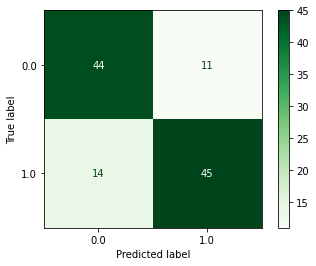

In [141]:
plot_confusion_matrix(best_modelo, x_test, y_test, cmap='Greens')

#**8. Teste prático da Emily**

Esta parte do código foi incluída no intuito de permitir um teste prático com a modelagem preditiva desenvolvida.

Utilizando a amostra de dados predita no TESTE do modelo, é possível verificar o nome de um colaborador, e se este foi predito como ATIVO ou DESLIGADO, a partir de uma interface simplificada.

Como foi utilizada a amostra de dados de TESTE, também foi adicionada a comparação com o valor real deste colaborador, onde é possível identificar se o modelo ACERTOU ou ERROU sua predição.

##8.1 Código do teste

In [142]:
testes = list(y_test.index)
n = 0
amostra = []
for i in testes:

  if i >= 423:
    continue

#//////////////////////////////////////////////////////
  if y_pred[n] != y_test.Situacao[i]:
    print(n, 'ERROU', i, integrated_dfs['Nome_Completo'][i], " == ", y_pred[n])

  if y_pred[n] == y_test.Situacao[i]:
    print(n, 'ACERTOU', i, integrated_dfs['Nome_Completo'][i], " == ", y_pred[n])
#//////////////////////////////////////////////////////

  amostra.append(integrated_dfs['Nome_Completo'][i])
  n += 1

0 ERROU 90 PC180  ==  0.0
1 ERROU 132 PC216  ==  0.0
2 ERROU 165 PC246  ==  0.0
3 ERROU 360 PC469  ==  1.0
4 ACERTOU 247 PC33  ==  0.0
5 ERROU 180 PC26  ==  0.0
6 ACERTOU 412 PC9  ==  1.0
7 ACERTOU 375 PC56  ==  1.0
8 ACERTOU 160 PC241  ==  1.0
9 ERROU 85 PC176  ==  0.0
10 ACERTOU 419 PC96  ==  1.0
11 ACERTOU 383 PC63  ==  1.0
12 ACERTOU 233 PC31  ==  1.0
13 ACERTOU 223 PC299  ==  0.0
14 ERROU 326 PC424  ==  1.0
15 ACERTOU 373 PC54  ==  1.0
16 ERROU 49 PC143  ==  0.0
17 ACERTOU 382 PC62  ==  1.0
18 ACERTOU 241 PC320  ==  0.0
19 ACERTOU 274 PC359  ==  0.0
20 ACERTOU 221 PC297  ==  0.0
21 ACERTOU 17 PC114  ==  1.0
22 ACERTOU 417 PC94  ==  1.0
23 ERROU 41 PC136  ==  0.0
24 ERROU 218 PC294  ==  1.0
25 ACERTOU 65 PC158  ==  1.0
26 ERROU 328 PC426  ==  1.0
27 ACERTOU 187 PC266  ==  1.0
28 ERROU 250 PC334  ==  1.0
29 ERROU 92 PC182  ==  0.0
30 ACERTOU 47 PC141  ==  1.0
31 ERROU 157 PC239  ==  0.0
32 ERROU 268 PC351  ==  1.0
33 ERROU 192 PC270  ==  0.0
34 ACERTOU 232 PC309  ==  0.0
35 ERROU 29

##8.2 Lista de funcionários da amostra

A lista abaixo inclui o nome dos colaboradores presentes na amostra de TESTE, podendo ser utilizados para verificar o valor de nomes individuais.

In [143]:
amostra.sort()
print(amostra)

['PC1', 'PC101', 'PC102', 'PC103', 'PC107', 'PC114', 'PC125', 'PC127', 'PC13', 'PC133', 'PC135', 'PC136', 'PC141', 'PC143', 'PC152', 'PC155', 'PC158', 'PC159', 'PC16', 'PC160', 'PC161', 'PC176', 'PC180', 'PC182', 'PC195', 'PC199', 'PC204', 'PC205', 'PC216', 'PC219', 'PC23', 'PC239', 'PC241', 'PC243', 'PC246', 'PC252', 'PC26', 'PC265', 'PC266', 'PC270', 'PC290', 'PC294', 'PC297', 'PC299', 'PC30', 'PC309', 'PC31', 'PC320', 'PC328', 'PC33', 'PC334', 'PC350', 'PC351', 'PC359', 'PC368', 'PC37', 'PC381', 'PC394', 'PC395', 'PC399', 'PC411', 'PC420', 'PC424', 'PC426', 'PC446', 'PC448', 'PC45', 'PC458', 'PC469', 'PC5', 'PC51', 'PC54', 'PC55', 'PC56', 'PC57', 'PC62', 'PC63', 'PC86', 'PC87', 'PC9', 'PC90', 'PC94', 'PC96', 'PC99']


##8.3 Campo para verificar a predição de um funcionário

Ao executar a célula abaixo, ela irá solicitar um INPUT, que deve ser preenchido utilizando qualquer um dos valores presentes na lista acima.

Exemplo: PC101

Observação: Caso o valor não corresponda a nenhum nome presente na lista, o código irá retornar o tratamento de excessão "Essa pessoa não está disponível na lista de predição".

In [144]:
person = str(input('Digite um nome de uma Pessoa Colaboradora presente na lista acima (Exemplo: PC[número]]): ')).upper()
# Index = integrated_dfs[integrated_dfs['Nome_Completo']==person].index

Index = int(integrated_dfs[integrated_dfs['Nome_Completo'] == person].index.values)

if Index in testes:
  n = testes.index(Index)

  if y_pred[n] == 1:
    situacao = "permanecerá ativo"
  else:
    situacao = "tende a se desligar"

  if y_pred[n] != integrated_dfs['Situacao'][Index]:
    print('ERROU', Index, integrated_dfs['Nome_Completo'][Index], " == ", y_pred[n], " || ", integrated_dfs['Situacao'][Index])
    print(f'O modelo indica que {person} {situacao} (Essa predição está incorreta!)')
    # c +=1
  if y_pred[n] == integrated_dfs['Situacao'][Index]:
    print('ACERTOU', Index, integrated_dfs['Nome_Completo'][Index], " == ", y_pred[n], " || ", integrated_dfs['Situacao'][Index])
    print(f'O modelo indica que {person} {situacao} (Essa predição está correta!)')
if Index not in testes:
  print('Essa pessoa não está disponível na lista de predição')
  n += 1

Digite um nome de uma Pessoa Colaboradora presente na lista acima (Exemplo: PC[número]]): pc265
ACERTOU 186 PC265  ==  1.0  ||  1.0
O modelo indica que PC265 permanecerá ativo (Essa predição está correta!)
